In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import scipy.io as sio
from dataclasses import dataclass
from typing import List, Tuple
import os
from dotenv import load_dotenv
load_dotenv()
import tidy3d as td
from tidy3d import web
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from natsort import natsorted
import numpy as np
import matplotlib.animation as animation
import xarray as xr
import h5py
import imageio
import matplotlib
import gc
import sys
import io
import matplotlib.colors as mcolors
import matplotlib.patches as patches
from scipy.optimize import curve_fit
import scipy.integrate

import scipy.ndimage

# Assuming /AutomationModule is in the root directory of your project
sys.path.append(os.path.abspath(rf'H:\phd stuff\tidy3d'))

from AutomationModule import * 

import AutomationModule as AM
plt.rcParams.update({'font.size': 22})  

tidy3dAPI = os.environ["API_TIDY3D_KEY"]
plt.rc('font', family='Arial')


In [2]:
folder_experimental = rf"H:\phd stuff\tidy3d\output\Experimental Data\data_lsu_air_decaline"
transmission_experimental_air = []
transmission_experimental_decaline = []

for filename in os.listdir(folder_experimental):
    if Path(filename).suffix == ".txt":
        continue

    with open(os.path.join(folder_experimental,filename), 'rb') as file:
        content = file.read()
        
    # Decode the binary content to a string
    decoded_content = content.decode('utf-8')

    # Split the content into lines
    lines = decoded_content.split('\r\n')

    # Initialize an empty list to store the parsed values
    data = []

    # Loop through each line and split by the comma
    for line in lines:
        if line:  # Skip any empty lines
            value1, value2 = line.split(',')
            data.append([float(value1), float(value2)])  # Convert values to float

    if "decaline" in filename:
        transmission_experimental_decaline.append((data))
    else: 
        transmission_experimental_air.append(data)


transmission_experimental_air = np.array(transmission_experimental_air)
transmission_experimental_decaline = np.array(transmission_experimental_decaline)

    

In [3]:
sizes_exp = [5.4,8.4,9.4,10.4,11.4,12.4,14.5,20.5]


In [4]:
#Simulation data 
data_sim = AM.read_hdf5_as_dict("20250912_far_field_hollow_n_3.42_ffh_0.1086_ffr_0.20_size_1.h5")

In [18]:
r_proj=(data_sim["r"])[0]
theta_proj=data_sim["theta"]
phi_proj=data_sim["phi"]
indices_15_30 = np.where(np.bool_(theta_proj*180/np.pi >=15) & np.bool_(theta_proj*180/np.pi <=30))[0]
r,theta,phi = r_proj,theta_proj[indices_15_30],phi_proj
projected_field_data_0=data_sim["power_far_field0"]
projected_field_data=data_sim["power_far_field"]

In [19]:
lambdas = (td.C_0/data_sim["freqs"])

In [20]:
theta_slice = theta_proj[indices_15_30]
dtheta = np.diff(theta_slice)

theta_mid = 0.5 * (theta_slice[:-1] + theta_slice[1:]) 

dA = (r ** 2) * np.sin(theta_mid) * dtheta * np.diff(phi)[1]

In [21]:
transmission_0_15_degrees = ((projected_field_data_0[indices_15_30[:-1],:,:])* dA[:,np.newaxis,np.newaxis]).sum(axis=(0,1))

In [22]:
transmission_normalized_15_degrees = ((projected_field_data[indices_15_30[:-1],:,:])* dA[:,np.newaxis,np.newaxis]).sum(axis=(0,1))/transmission_0_15_degrees 

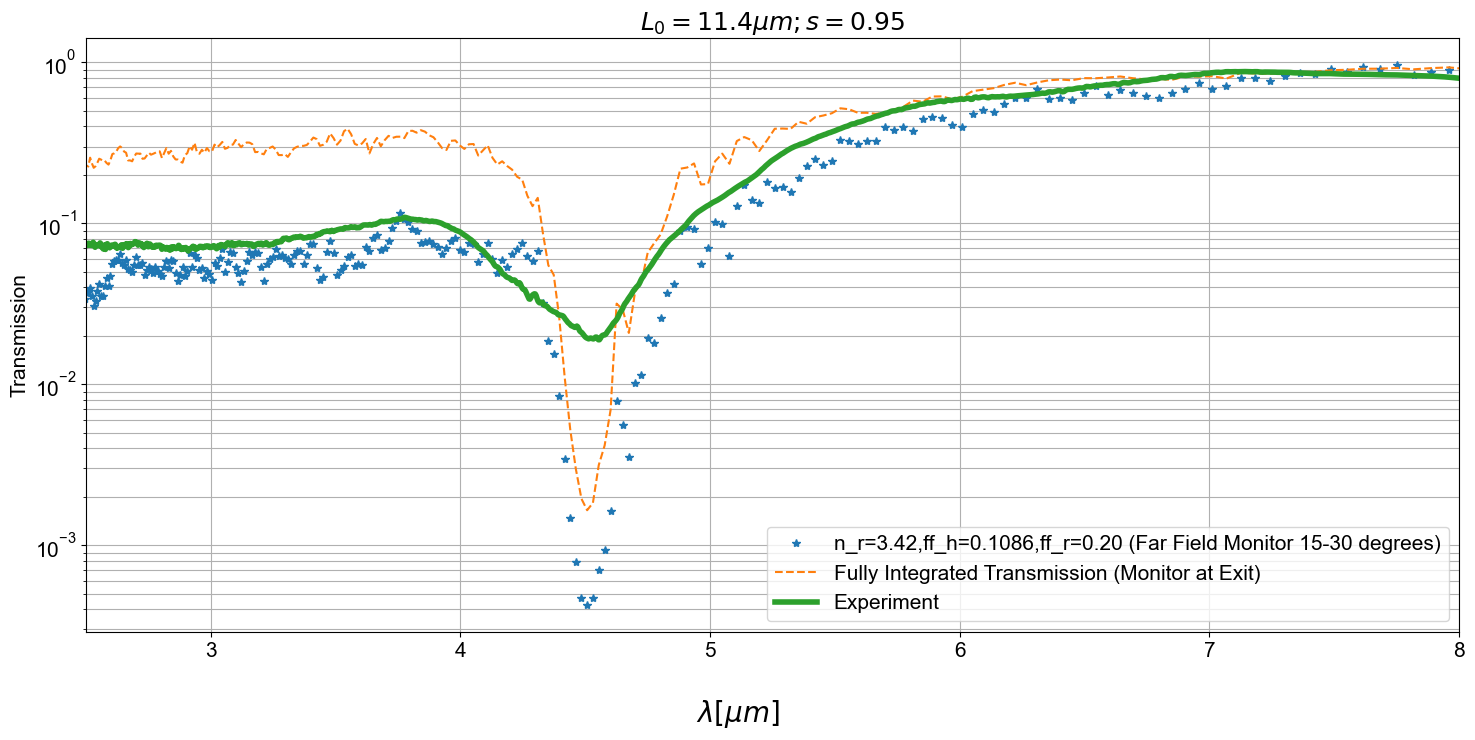

In [27]:
plt.rcParams.update({'font.size': 15})  
fig, ax = plt.subplots(figsize=(15, 7.5))

ax.plot(lambdas*0.95,transmission_normalized_15_degrees,"*",label=rf"n_r=3.42,ff_h=0.1086,ff_r=0.20 (Far Field Monitor 15-30 degrees)")
ax.plot(lambdas*0.95,data_sim["transmission_exit"],"--",label=rf"Fully Integrated Transmission (Monitor at Exit)")
ax.plot((1e4/transmission_experimental_air[4,:,0]),transmission_experimental_air[4,:,1],linewidth=4,label=rf"Experiment")

# adjust =0.875
ax.legend(loc=4)
ax.grid(True, which="both")
ax.set_yscale("log")
ax.set_xlim(2.5,8)
ax.set_ylabel("Transmission")
ax.set_title(rf"$L_0=11.4\mu m; s=0.95$")


fig.supxlabel(rf'$\lambda [\mu m]$', fontsize=20)
plt.tight_layout()
plt.show()
